In [1]:
import requests
import pandas as pd
import numpy as np
from binance.spot import Spot
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.tsa.stattools import coint
from datetime import datetime, timedelta
from scipy.signal import correlate
from scipy.stats import pointbiserialr, pearsonr, ttest_ind, f_oneway, t
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from matplotlib.table import Table
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression

In [3]:
def retrieve_data_from_binance(symbol="BTCUSDT", interval="1d", start_date="2020-12-01", end_date="2025-05-01"):
    """
    Retrieve historical price data from Binance for a given symbol and time interval.
    
    Parameters:
    - symbol: Trading pair symbol (default: "BTCUSDT")
    - interval: Time interval for data (default: "1d")
    - start_date: Start date for data retrieval (default: "2020-12-01")
    - end_date: End date for data retrieval (default: "2025-05-01")
    
    Returns:
    - DataFrame with 'Date' and 'Close' columns
    """
    client = Spot()
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)
    all_klines = []
    while start_timestamp < end_timestamp:
        klines = client.klines(symbol, interval, startTime=start_timestamp, endTime=end_timestamp, limit=1000)
        if not klines:
            break
        all_klines.extend(klines)
        start_timestamp = klines[-1][0] + 1
    columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume',
               'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore']
    df = pd.DataFrame(all_klines, columns=columns)
    df['Date'] = pd.to_datetime(df['Open Time'], unit='ms', utc=True)
    df['Close'] = df['Close'].astype(float)
    return df[['Date', 'Close']].sort_values('Date')

In [5]:
def load_news_from_csv(file_path):
    """
    Load news data from a CSV file and process the 'Published At' column.
    
    Parameters:
    - file_path: Path to the CSV file containing news data
    
    Returns:
    - DataFrame with 'Published At' and 'Title' columns
    """
    try:
        news_df = pd.read_csv(file_path)
        news_df['Published At'] = pd.to_datetime(
            news_df['date'] + ' ' + news_df['time'],
            format='%Y-%m-%d %H:%M:%S',
            utc=True
        )
        news_df = news_df[['Published At', 'summary']].rename(columns={'summary': 'Title'})
        print(f"Loaded {len(news_df)} news entries from CSV.")
        return news_df
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return pd.DataFrame(columns=['Published At', 'Title'])


In [7]:
def analyze_sentiment(text):
    """
    Analyze the sentiment of a given text using VADER sentiment analyzer.
    
    Parameters:
    - text: Text to analyze
    
    Returns:
    - Compound sentiment score
    """
    if text is None or pd.isna(text):
        return 0.0
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores['compound']


In [9]:
def process_news_sentiment(news_df):
    """
    Compute sentiment for news titles and assign event numbers.
    
    Parameters:
    - news_df: DataFrame with news data
    
    Returns:
    - Processed DataFrame with sentiment and event numbers
    """
    news_df['Sentiment'] = news_df['Title'].apply(analyze_sentiment)
    news_df = news_df.sort_values('Published At').reset_index(drop=True)
    news_df['Event_Number'] = news_df.index + 1
    return news_df

In [52]:
def plot_sentiment_with_news(price_df, news_df):
    """
    Plot Bitcoin price data with sentiment markers and a separate news table.
    
    Parameters:
    - price_df: DataFrame with 'Date' and 'Close' columns
    - news_df: DataFrame with 'Published At', 'Title', 'Sentiment', and 'Event_Number' columns
    """
    # Create figure with gridspec for better subplot control
    fig = plt.figure(figsize=(14, 16))
    gs = GridSpec(2, 1, height_ratios=[1, 1.5], hspace=0.4)  # Increased height for table and spacing
    
    # Price chart subplot
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(price_df['Date'], price_df['Close'], label='BTC Price', color='black', linewidth=2)
    ax1.set_title('Bitcoin Price with Numbered Sentiment Signals (2021–2025)', fontsize=14)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Price (USD)', fontsize=12, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(alpha=0.3)
    
    max_price = price_df['Close'].max()
    for idx, row in news_df.iterrows():
        news_datetime = row['Published At']
        event_number = row['Event_Number']
        sentiment = row['Sentiment']
        try:
            # Find the closest price date
            price_row = price_df.iloc[(price_df['Date'] - news_datetime).abs().argsort()[:1]]
            price = price_row['Close'].values[0]
            plot_date = price_row['Date'].values[0]
        except IndexError:
            continue
        
        if sentiment > 0.05:
            # Green upward arrow for positive sentiment
            ax1.annotate('', xy=(plot_date, price * 1.02), xytext=(plot_date, price),
                         arrowprops=dict(facecolor='green', shrink=0.05, width=2, headwidth=8))
            ax1.text(plot_date, price * 1.05, str(event_number), color='green', fontsize=8, ha='center', va='bottom')
        elif sentiment < -0.05:
            # Red downward arrow for negative sentiment
            ax1.annotate('', xy=(plot_date, price * 0.98), xytext=(plot_date, price),
                         arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8))
            ax1.text(plot_date, price * 0.95, str(event_number), color='red', fontsize=8, ha='center', va='top')
        else:
            # Blue circle for neutral sentiment
            ax1.scatter(plot_date, price, color='blue', s=100, marker='o')
            ax1.text(plot_date, price * 1.05, str(event_number), color='blue', fontsize=8, ha='center', va='bottom')
    
    # Legend for price chart
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label='BTC Price'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Positive Sentiment'),
        Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Negative Sentiment'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Neutral Sentiment')
    ]
    ax1.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    # News and sentiment table subplot
    ax2 = fig.add_subplot(gs[1])
    ax2.axis('off')  # Hide axes for table
    
    # Set table title above the table
    ax2.set_title('News Events and Sentiment Scores', fontsize=14, pad=20, loc='center')
    
    # Prepare table data with Date
    table_data = news_df[['Event_Number', 'Published At', 'Title', 'Sentiment']].values.tolist()
    
    # Format table data
    for row in table_data:
        # Format date as YYYY-MM-DD
        row[1] = row[1].strftime('%Y-%m-%d')
        # Truncate title for display
        title = row[2]
        if len(title) > 80:
            row[2] = title[:77] + '...'
        # Format sentiment to 4 decimals
        row[3] = f"{row[3]:.4f}"
    
    # Create table below the title
    table = Table(ax2, bbox=[0, -0.9, 1, 1.8])  # Adjusted bbox to position below title and fit 50 rows
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    
    # Define column widths
    col_widths = [0.05, 0.15, 0.65, 0.15]  # Event #, Date, Title, Sentiment
    n_rows = len(table_data)
    n_cols = 4
    
    # Add cells
    for i in range(n_rows):
        for j in range(n_cols):
            table.add_cell(i, j, col_widths[j], 0.035, text=table_data[i][j], loc='left')
    
    # Add header
    table.add_cell(-1, 0, col_widths[0], 0.035, text='Event #', loc='center')
    table.add_cell(-1, 1, col_widths[1], 0.035, text='Date', loc='center')
    table.add_cell(-1, 2, col_widths[2], 0.035, text='News Title', loc='center')
    table.add_cell(-1, 3, col_widths[3], 0.035, text='Sentiment', loc='center')
    
    ax2.add_table(table)
    
    # Adjust layout to prevent overlap
    plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.4)
    plt.savefig('bitcoin_sentiment_sample.png', dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
def analyze_price_movements(price_df, news_df, strategy='lookahead', windows=[1, 7], max_window=30, price_col='Close_binance'):
    """
    Analyze price movements based on news events for a given strategy.
    
    Parameters:
    - price_df: DataFrame with price data
    - news_df: DataFrame with news data
    - strategy: Trading strategy ('lookahead' or 'slow') (default: 'lookahead')
    - windows: List of time windows for returns calculation (default: [1, 7])
    - max_window: Maximum time window for trade closure (default: 30)
    - price_col: Column name for price data (default: 'Close_binance')
    
    Returns:
    - DataFrame with price movement analysis
    """
    completed_results = []
    ongoing_results = []
    # Use the daily price data
    daily_price_df = price_df.reset_index()
    daily_price_df['Open Time'] = pd.to_datetime(daily_price_df['Date'])
    print(f"Daily price data range: {daily_price_df['Open Time'].min()} to {daily_price_df['Open Time'].max()}")
    print(f"News data range: {news_df['Published At'].min()} to {news_df['Published At'].max()}")

    # Get the latest available price date
    latest_price_date = daily_price_df['Open Time'].max().date()
    
    # Sort news by date for sequential processing
    news_df = news_df.sort_values('Published At').reset_index(drop=True)
    
    for idx, news in news_df.iterrows():
        news_date = news['Published At'].date()
        sentiment = news['Sentiment']
        title = news['Title']
        
        if strategy == 'lookahead':
            base_date = news_date - timedelta(days=1)
        else:  # strategy == 'slow'
            base_date = news_date
            
        try:
            price_at_base = daily_price_df[daily_price_df['Open Time'].dt.date == base_date][price_col].iloc[0]
        except IndexError:
            print(f"No price data for base date {base_date} (Title: {title[:50]}...)")
            continue
            
        window_results = {
            'Title': title,
            'Published At': news_date,
            'Sentiment': sentiment,
            'Price_At_Base': price_at_base
        }

        # Determine close date: next news with different sentiment or 30 days
        close_date = base_date + timedelta(days=max_window)
        close_days = max_window
        close_reason = '30 Days'
        
        # Check for next news with different sentiment
        for next_idx in range(idx + 1, len(news_df)):
            next_news_date = news_df.iloc[next_idx]['Published At'].date()
            next_sentiment = news_df.iloc[next_idx]['Sentiment']
            days_to_next = (next_news_date - base_date).days
            # Consider sentiment change if within max_window
            if days_to_next <= max_window:
                # Different sentiment: positive to negative, negative to positive, or neutral to non-neutral
                if (sentiment > 0 and next_sentiment <= 0) or (sentiment < 0 and next_sentiment >= 0) or (sentiment == 0 and next_sentiment != 0) or (sentiment != 0 and next_sentiment == 0):
                    close_date = next_news_date
                    close_days = days_to_next
                    close_reason = 'Next News'
                    break
        
        # Check if trade is ongoing (close_date > latest_price_date)
        is_ongoing = close_date > latest_price_date
        if is_ongoing:
            close_date = latest_price_date
            close_days = (latest_price_date - base_date).days
        
        # Calculate returns for windows and close
        for days in windows + [close_days]:
            if days > close_days and days != close_days:
                window_results[f'Returns_{days}d'] = np.nan
                continue
            end_date = base_date + timedelta(days=days)
            if end_date > latest_price_date:
                end_date = latest_price_date
                actual_days = (latest_price_date - base_date).days
            else:
                actual_days = days
                
            try:
                price_at_end = daily_price_df[daily_price_df['Open Time'].dt.date == end_date][price_col].iloc[0]
                returns = (price_at_end - price_at_base) / price_at_base * 100
                if is_ongoing and days == close_days:
                    col_name = f'Returns_{actual_days}d'
                elif not is_ongoing and days == close_days:
                    col_name = 'Returns_Close'
                else:
                    col_name = f'Returns_{days}d'
                window_results[col_name] = returns
            except IndexError:
                if is_ongoing and days == close_days:
                    col_name = f'Returns_{actual_days}d'
                elif not is_ongoing and days == close_days:
                    col_name = 'Returns_Close'
                else:
                    col_name = f'Returns_{days}d'
                window_results[col_name] = np.nan
        
        # Add Close_Days and Close_Reason only for completed trades
        if not is_ongoing:
            window_results['Close_Days'] = close_days
            window_results['Close_Reason'] = close_reason

        # Store in appropriate list
        if is_ongoing:
            ongoing_results.append(window_results)
        else:
            completed_results.append(window_results)
    
    # Create DataFrames
    completed_df = pd.DataFrame(completed_results)
    ongoing_df = pd.DataFrame(ongoing_results)
    
    # Display completed trades
    if not completed_df.empty:
        print(f"\nCompleted Trades ({strategy} strategy):")
        display_cols = ['Title', 'Published At', 'Sentiment', 'Returns_1d', 'Returns_7d', 'Returns_Close', 'Close_Days', 'Close_Reason']
        display_df = completed_df[display_cols].copy()
        display_df['Title'] = display_df['Title'].str[:50] + display_df['Title'].str[50:].apply(lambda x: '...' if x else '')
        display_df['Published At'] = display_df['Published At'].astype(str)
        pd.set_option('display.float_format', '{:.4f}'.format)
        print(display_df.to_string(index=False))
    else:
        print(f"No completed trades for {strategy} strategy.")
    
    # Display ongoing trades
    if not ongoing_df.empty:
        print(f"\nOngoing Trades ({strategy} strategy):")
        return_cols = [col for col in ongoing_df.columns if col.startswith('Returns_')]
        display_cols = ['Title', 'Published At', 'Sentiment'] + return_cols
        display_df = ongoing_df[display_cols].copy()
        display_df['Title'] = display_df['Title'].str[:50] + display_df['Title'].str[50:].apply(lambda x: '...' if x else '')
        display_df['Published At'] = display_df['Published At'].astype(str)
        pd.set_option('display.float_format', '{:.4f}'.format)
        print(display_df.to_string(index=False))
    else:
        print(f"No ongoing trades for {strategy} strategy.")
    
    # Combine both for return
    movement_df = pd.concat([completed_df, ongoing_df], ignore_index=True)
    if movement_df.empty:
        print(f"Warning: No price movements recorded for {strategy} strategy. Check price data alignment.")
    
    return movement_df

In [15]:
def analyze_statistics(movement_df, strategy_name):
    """
    Perform statistical tests to analyze the relationship between sentiment and returns.
    
    Parameters:
    - movement_df: DataFrame with columns ['Sentiment', 'Returns_1d', 'Returns_7d', 'Returns_Close', 'Returns_Xd']
    - strategy_name: Name of the strategy (e.g., 'lookahead' or 'slow')
    
    Returns:
    - Dictionary with statistical results including correlations, t-tests, and ANOVA
    """
    if movement_df.empty or 'Sentiment' not in movement_df.columns:
        print(f"Error: No valid movement data for {strategy_name}.")
        return
    
    print(f"\nStatistical Analysis for {strategy_name}:\n")
    
    # Create a copy of movement_df to avoid modifying the original
    df = movement_df.copy()
    
    # Combine Returns_Close and Returns_Xd into a single Returns_Close column
    return_cols = [col for col in df.columns if col.startswith('Returns_') and col != 'Returns_1d' and col != 'Returns_7d' and col != 'Returns_Close']
    if return_cols:
        df['Returns_Close'] = df.apply(
            lambda row: row[return_cols[0]] if pd.notna(row[return_cols[0]]) else row['Returns_Close'],
            axis=1
        )
    
    # Compute Adjusted Returns and Sentiment_Sign
    df['Sentiment_Label'] = pd.cut(
        df['Sentiment'],
        bins=[-1, -0.05, 0.05, 1],
        labels=['Negative', 'Neutral', 'Positive']
    )
    df['Sentiment_Sign'] = np.sign(df['Sentiment'])
    df['Sentiment_Sign'] = df['Sentiment_Sign'].where(df['Sentiment_Label'] != 'Neutral', 0)
    
    for window in ['Returns_1d', 'Returns_7d', 'Returns_Close']:
        df[f'Adjusted_{window}'] = df[window] * df['Sentiment_Sign']
    
    # Columns for descriptive statistics
    analysis_cols = ['Sentiment', 'Returns_1d', 'Adjusted_Returns_1d', 'Returns_7d', 'Adjusted_Returns_7d', 'Returns_Close', 'Adjusted_Returns_Close']
    
    # Descriptive Statistics
    print("1. Descriptive Statistics:")
    desc_stats = df[analysis_cols].describe()
    print(desc_stats.to_string())
    
    # Pearson Correlation Analysis (Continuous Sentiment)
    print("\n2. Pearson Correlation Analysis (Continuous Sentiment):")
    correlations = {}
    for window in ['Returns_1d', 'Returns_7d', 'Returns_Close']:
        valid_data = df[['Sentiment', window]].dropna()
        if len(valid_data) > 5:
            corr, p_value = pearsonr(valid_data['Sentiment'], valid_data[window])
            correlations[window] = {'Correlation': corr, 'P-Value': p_value}
            print(f"{window}: Correlation = {corr:.4f}, P-Value = {p_value:.4f}")
        else:
            print(f"{window}: Not enough data for correlation")
    
    # Point-Biserial Correlation Analysis (Sentiment Sign)
    print("\n3. Point-Biserial Correlation Analysis (Sentiment Sign):")
    sign_correlations = {}
    for window in ['Returns_1d', 'Returns_7d', 'Returns_Close']:
        valid_data = df[['Sentiment_Sign', window]].dropna()
        if len(valid_data) > 5 and valid_data['Sentiment_Sign'].nunique() > 1:
            corr, p_value = pointbiserialr(valid_data['Sentiment_Sign'], valid_data[window])
            sign_correlations[window] = {'Correlation': corr, 'P-Value': p_value}
            print(f"{window}: Correlation = {corr:.4f}, P-Value = {p_value:.4f}")
        else:
            print(f"{window}: Not enough data or variability for correlation")
    
    # Sentiment Group Analysis
    print("\n4. Sentiment Group Analysis:")
    group_stats = df.groupby('Sentiment_Label', observed=True)[['Returns_1d', 'Returns_7d', 'Returns_Close']].agg(['mean', 'count'])
    print(group_stats.to_string())
    
    # T-Test: Positive vs. Negative Sentiment
    print("\n5. T-Test (Positive vs. Negative Sentiment):")
    pos_returns = df[df['Sentiment_Label'] == 'Positive'][['Returns_1d', 'Returns_7d', 'Returns_Close']]
    neg_returns = df[df['Sentiment_Label'] == 'Negative'][['Returns_1d', 'Returns_7d', 'Returns_Close']]
    t_test_results = {}
    for window in ['Returns_1d', 'Returns_7d', 'Returns_Close']:
        valid_pos = pos_returns[window].dropna()
        valid_neg = neg_returns[window].dropna()
        if len(valid_pos) > 1 and len(valid_neg) > 1:
            t_stat, p_val = ttest_ind(valid_pos, neg_returns[window].dropna(), equal_var=False)  # Welch's t-test
            t_test_results[window] = {'T-Statistic': t_stat, 'P-Value': p_val}
            print(f"{window}: T-Statistic = {t_stat:.4f}, P-Value = {p_val:.4f}")
        else:
            print(f"{window}: Not enough data for t-test")
    
    # ANOVA
    print("\n6. ANOVA (Differences Across Sentiment Groups):")
    anova_results = {}
    for window in ['Returns_1d', 'Returns_7d', 'Returns_Close']:
        groups = [
            df[df['Sentiment_Label'] == label][window].dropna()
            for label in ['Negative', 'Neutral', 'Positive']
            if not df[df['Sentiment_Label'] == label][window].dropna().empty
        ]
        if len(groups) >= 2:
            f_stat, p_val = f_oneway(*groups)
            anova_results[window] = {'F-Statistic': f_stat, 'P-Value': p_val}
            print(f"{window}: F-Statistic = {f_stat:.4f}, P-Value = {p_val:.4f}")
        else:
            print(f"{window}: Not enough groups for ANOVA")
    
    return {'correlations': correlations, 'sign_correlations': sign_correlations, 't_test': t_test_results, 'anova': anova_results}

In [19]:
def plot_news_impact(movement_df, strategy_name):
    """
    Visualize the impact of news sentiment on price movements for a given strategy.
    
    Parameters:
    - movement_df: DataFrame with movement data
    - strategy_name: Name of the strategy
    """
    if movement_df.empty or 'Sentiment' not in movement_df.columns:
        print(f"Cannot plot: No valid movement data for {strategy_name}.")
        return
    
    movement_df['Sentiment_Label'] = pd.cut(
        movement_df['Sentiment'],
        bins=[-1, -0.05, 0.05, 1],
        labels=['Negative', 'Neutral', 'Positive']
    )
    # Restrict to Returns_1d, Returns_7d, Returns_Close
    windows = ['Returns_1d', 'Returns_7d', 'Returns_Close']
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    
    for window in windows:
        if window in movement_df.columns:
            means = movement_df.groupby('Sentiment_Label', observed=True)[window].mean().reindex(sentiment_labels)
            plt.figure(figsize=(8, 5))
            bars = means.plot(kind='bar', color=['red', 'gray', 'green'])
            plt.title(f'Average Bitcoin Price Change ({window}) by News Sentiment - {strategy_name}')
            plt.ylabel('Price Change (%)')
            plt.xlabel('Sentiment')
            plt.tight_layout()
            
            for bar in bars.containers:
                bars.bar_label(bar, fmt='%.2f', label_type='edge')
            
            plt.savefig(f'sentiment_impact_{window.lower()}_{strategy_name.lower().replace(" ", "_")}.png', dpi=300)
            plt.show()  # Display the plot
        else:
            print(f"Cannot plot {window}: Not found in movement_df")

In [21]:
def simulate_trading(movement_df, strategy_name, initial_cash=10000, fee=0.001):
    """
    Simulate trading based on sentiment-driven buy/sell strategy with transaction fees.
    
    Parameters:
    - movement_df: DataFrame with columns ['Sentiment', 'Returns_Close', 'Title', 'Published At', 'Price_At_Base']
    - strategy_name: Name of the strategy (e.g., 'Look-Ahead Bias' or 'Slow Reaction')
    - initial_cash: Initial portfolio value (default: 10000)
    - fee: Transaction fee per trade (default: 0.001)
    
    Returns:
    - results_df: DataFrame with performance metrics
    - trades_df: DataFrame with trade details
    """
    portfolio_value = initial_cash
    adjusted_returns = []
    trades = []
    portfolio_values = [initial_cash]  # Initial portfolio value

    for _, row in movement_df.iterrows():
        sentiment = row['Sentiment']
        returns_close = row['Returns_Close']
        title = row['Title']
        published_at = row['Published At']
        price_at_base = row['Price_At_Base']

        # Skip if Returns_Close is NaN or sentiment is neutral
        if pd.isna(returns_close) or sentiment == 0:
            portfolio_values.append(portfolio_value)  # No trade, portfolio unchanged
            continue

        # Buy/Sell logic
        action = 'Buy' if sentiment > 0 else 'Sell'
        # Adjusted return: Apply fee to the return
        # For Buy: (1 + Returns_Close/100) * (1 - fee) - 1
        # For Sell: (1 - Returns_Close/100) * (1 - fee) - 1
        if sentiment > 0:
            trade_return = (1 + returns_close / 100) * (1 - fee) - 1
        else:
            trade_return = (1 - returns_close / 100) * (1 - fee) - 1
        adjusted_return = trade_return * 100  # Convert back to percentage

        # Update portfolio value
        portfolio_value *= (1 + trade_return)
        portfolio_values.append(portfolio_value)

        adjusted_returns.append(adjusted_return)
        trades.append({
            'Title': title[:50] + ('...' if len(title) > 50 else ''),
            'Published At': published_at,
            'Sentiment': sentiment,
            'Action': action,
            'Returns_Close': returns_close,
            'Adjusted_Return': adjusted_return,
            'Portfolio_Value': portfolio_value
        })

    trades_df = pd.DataFrame(trades)

    # Calculate performance metrics
    if adjusted_returns:
        total_return = (portfolio_value - initial_cash) / initial_cash * 100
        avg_return = np.mean(adjusted_returns)
        win_rate = (np.sum(np.array(adjusted_returns) > 0) / len(adjusted_returns)) * 100
        num_trades = len(adjusted_returns)
    else:
        total_return = 0
        avg_return = 0
        win_rate = 0
        num_trades = 0

    # Display trades
    if not trades_df.empty:
        print(f"\nTrades for {strategy_name} strategy (with fees):")
        display_df = trades_df[['Title', 'Published At', 'Sentiment', 'Action', 'Returns_Close', 'Adjusted_Return', 'Portfolio_Value']].copy()
        display_df['Published At'] = display_df['Published At'].astype(str)
        pd.set_option('display.float_format', '{:.4f}'.format)
        print(display_df.to_string(index=False))
    else:
        print(f"No valid trades for {strategy_name} strategy (neutral sentiment or NaN returns).")

    # Performance metrics
    results = {
        'Strategy': strategy_name,
        'Total Return (%)': total_return,
        'Average Return per Trade (%)': avg_return,
        'Win Rate (%)': win_rate,
        'Number of Trades': num_trades,
        'Portfolio_Values': portfolio_values
    }

    print(f"\nPerformance Metrics for {strategy_name} strategy (with fees):")
    for key, value in results.items():
        if key != 'Portfolio_Values':
            if isinstance(value, float):
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")

    return pd.DataFrame([results]), trades_df

In [23]:
def plot_portfolio_value(lookahead_results, slow_results):
    """
    Plot portfolio value over time for Look-Ahead Bias and Slow Reaction strategies.
    
    Parameters:
    - lookahead_results: DataFrame from simulate_trading for Look-Ahead Bias
    - slow_results: DataFrame from simulate_trading for Slow Reaction
    """
    plt.figure(figsize=(10, 6))
    plt.plot(lookahead_results['Portfolio_Values'].iloc[0], label="Look-Ahead Bias", color='blue')
    plt.plot(slow_results['Portfolio_Values'].iloc[0], label="Slow Reaction", color='orange')
    plt.title("Portfolio Value Over Time (with Transaction Fees)")
    plt.xlabel("Trade Event")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('portfolio_values_with_fees.png', dpi=300)
    plt.show()


Loaded 50 news entries from CSV.
Retrieving hourly price data from 2020-12-30 to 2025-05-09

=== Slow Reaction Strategy Analysis ===

Price Movement Analysis:
Daily price data range: 2020-12-30 00:00:00+00:00 to 2025-05-05 15:00:00+00:00
News data range: 2021-01-29 07:00:00+00:00 to 2025-04-09 07:30:00+00:00

Completed Trades (slow strategy):
                                                Title Published At  Sentiment  Returns_1d  Returns_7d  Returns_Close  Close_Days Close_Reason
Elon Musk changes his X bio to “#bitcoin,” prompti...   2021-01-29     0.4199      0.2924      8.3250        35.7119          30      30 Days
X users amplify rumors of Tesla’s Bitcoin purchase...   2021-02-05     0.3612      4.7243     29.7264        33.0060          30      30 Days
@whale_alert posts about a large BTC transfer to a...   2021-03-10    -0.3400      0.1649      1.8169         5.0292          30      30 Days
Turkey bans crypto payments, with X posts warning ...   2021-04-15    -0.3400      1.04

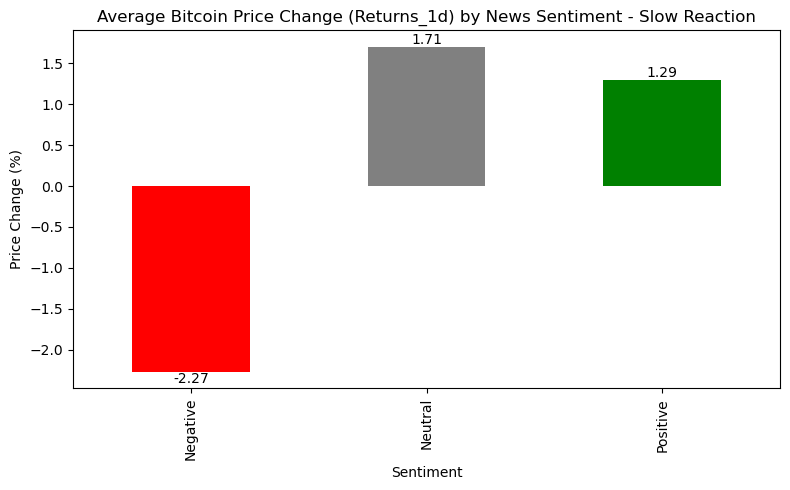

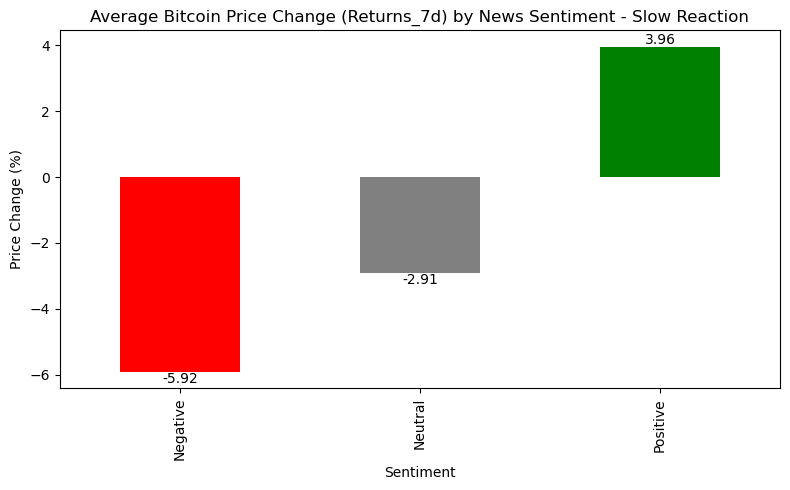

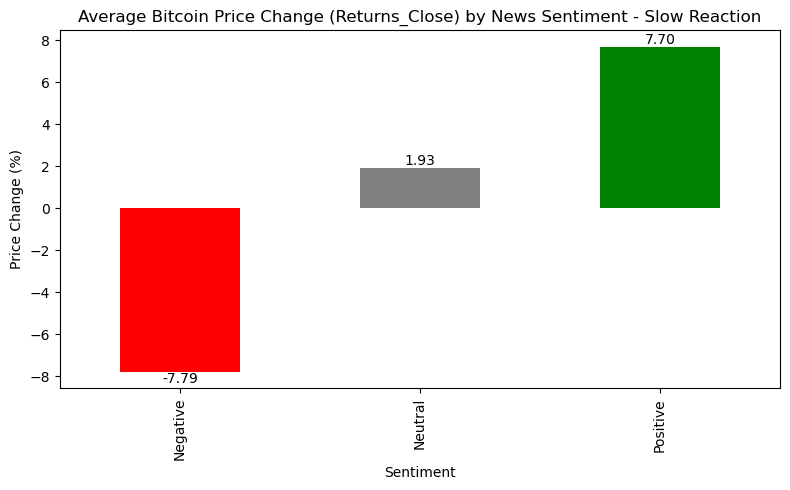


=== Look-Ahead Bias Strategy Analysis ===

Price Movement Analysis:
Daily price data range: 2020-12-30 00:00:00+00:00 to 2025-05-05 15:00:00+00:00
News data range: 2021-01-29 07:00:00+00:00 to 2025-04-09 07:30:00+00:00

Completed Trades (lookahead strategy):
                                                Title Published At  Sentiment  Returns_1d  Returns_7d  Returns_Close  Close_Days Close_Reason
Elon Musk changes his X bio to “#bitcoin,” prompti...   2021-01-29     0.4199     11.3406     24.0980        54.9468          30      30 Days
X users amplify rumors of Tesla’s Bitcoin purchase...   2021-02-05     0.3612     -2.8109     16.2542        28.2291          30      30 Days
@whale_alert posts about a large BTC transfer to a...   2021-03-10    -0.3400      6.7085      3.9764         8.4755          30      30 Days
Turkey bans crypto payments, with X posts warning ...   2021-04-15    -0.3400     -0.9635    -12.0588       -20.9828          30      30 Days
Elon Musk tweets Tesla will st

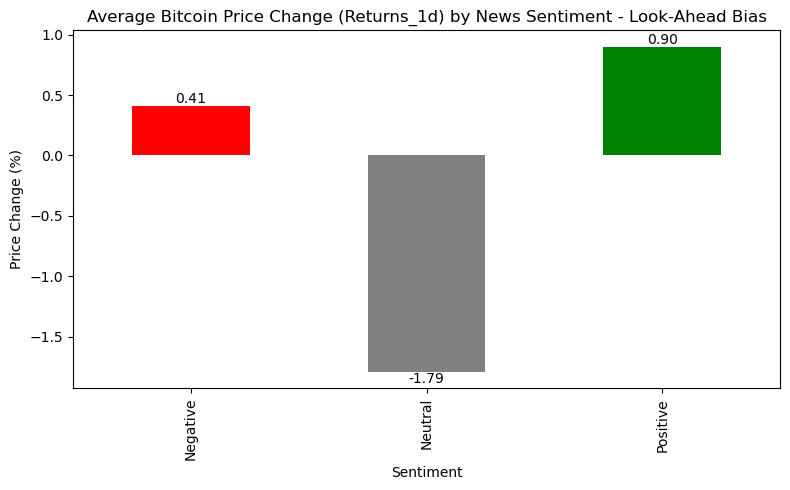

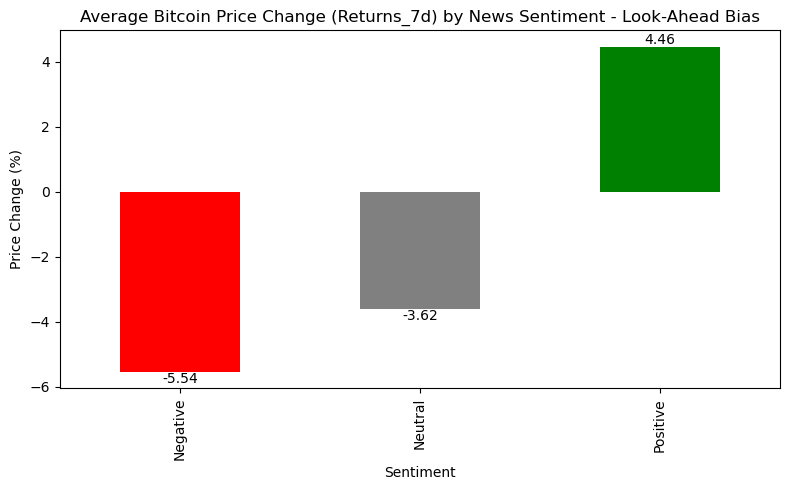

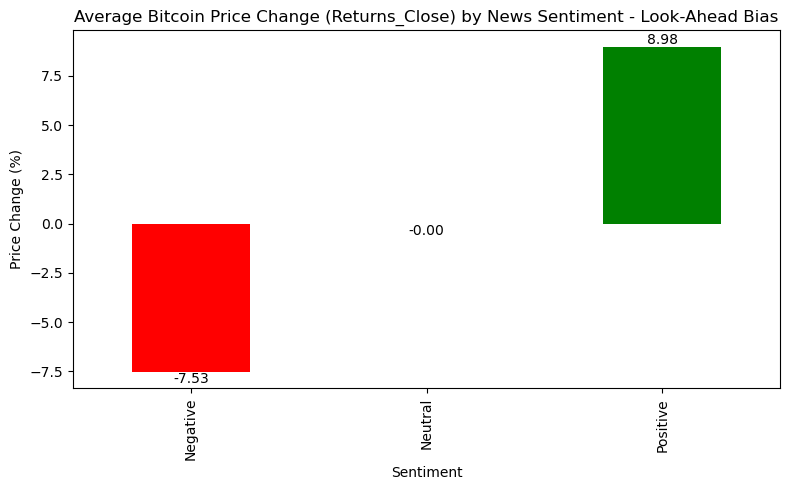


=== Combined Trading Summary ===

Trading Summary (with fees):
          Strategy  Total Return (%)  Average Return per Trade (%)  \
0  Look-Ahead Bias         2309.4535                        8.4439   
0    Slow Reaction         1687.1351                        7.6169   

   Win Rate (%)  Number of Trades  \
0       63.6364                44   
0       61.3636                44   

                                    Portfolio_Values  
0  [10000, 15479.186762719964, 19828.979276615308...  
0  [10000, 13557.622909128282, 18014.42236878789,...  

Plotting Portfolio Value:


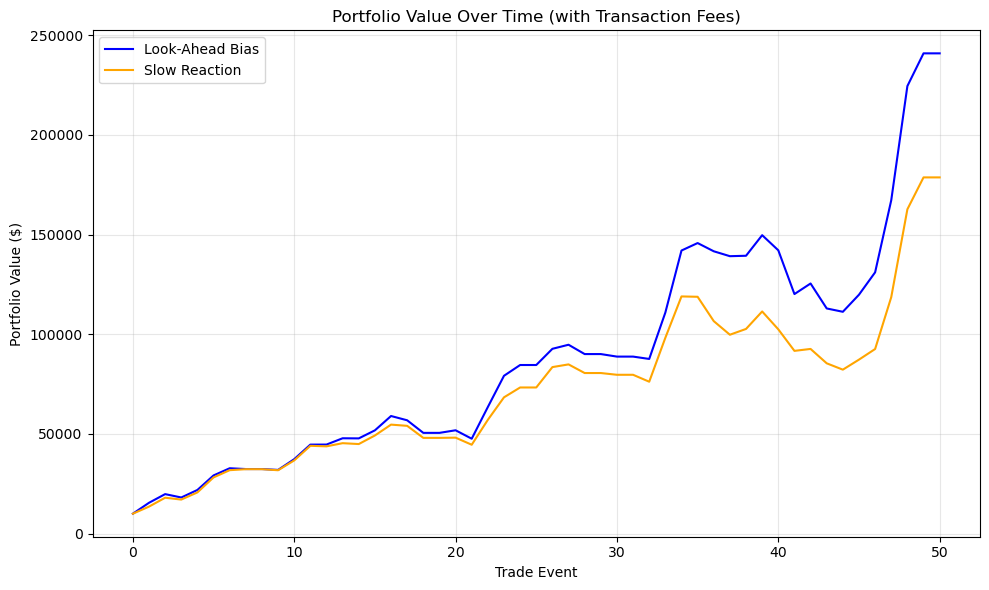

In [25]:
def main():
    """
    Main function to execute the trading analysis pipeline.
    """
    csv_path = r"C:\Users\Acer\Downloads\ftec4008\bitcoin news.csv"
    news_df = load_news_from_csv(csv_path)
    if news_df.empty:
        print("No news data loaded. Exiting.")
        return
    start_date = (news_df['Published At'].min() - timedelta(days=30)).strftime('%Y-%m-%d')
    end_date = (news_df['Published At'].max() + timedelta(days=30)).strftime('%Y-%m-%d')
    print(f"Retrieving hourly price data from {start_date} to {end_date}")
    try:
        df_binance = retrieve_data_from_binance(
            symbol="BTCUSDT",
            interval="1h",
            start_date=start_date,
            end_date=end_date
        )
    except Exception as e:
        print(f"Error retrieving data: {e}")
        return
    df_binance = df_binance.set_index('Date')
    news_df_processed = process_news_sentiment(news_df.copy())
    
    # Slow Reaction Strategy Analysis
    print("\n=== Slow Reaction Strategy Analysis ===")
    
    print("\nPrice Movement Analysis:")
    movement_df_slow = analyze_price_movements(
        df_binance,
        news_df_processed,
        strategy='slow',
        windows=[1, 7],
        price_col='Close'
    )
    
    print("\nSimulated Trading Analysis (with fees):")
    profit_slow, trades_slow = simulate_trading(movement_df_slow, "Slow Reaction")
    
    print("\nStatistical Analysis:")
    summarize_news_impact(movement_df_slow, "Slow Reaction")
    stats_slow = analyze_statistics(movement_df_slow, "Slow Reaction")
    
    print("\nPlotting News Impact:")
    plot_news_impact(movement_df_slow, "Slow Reaction")
    
    # Look-Ahead Bias Strategy Analysis
    print("\n=== Look-Ahead Bias Strategy Analysis ===")
    
    print("\nPrice Movement Analysis:")
    movement_df_lookahead = analyze_price_movements(
        df_binance,
        news_df_processed,
        strategy='lookahead',
        windows=[1, 7],
        price_col='Close'
    )
    
    print("\nSimulated Trading Analysis (with fees):")
    profit_lookahead, trades_lookahead = simulate_trading(movement_df_lookahead, "Look-Ahead Bias")
    
    print("\nStatistical Analysis:")
    summarize_news_impact(movement_df_lookahead, "Look-Ahead Bias")
    stats_lookahead = analyze_statistics(movement_df_lookahead, "Look-Ahead Bias")
    
    print("\nPlotting News Impact:")
    plot_news_impact(movement_df_lookahead, "Look-Ahead Bias")
    
    # Combined Trading Summary and Portfolio Plot
    print("\n=== Combined Trading Summary ===")
    print("\nTrading Summary (with fees):")
    print(pd.concat([profit_lookahead, profit_slow]))
    
    print("\nPlotting Portfolio Value:")
    plot_portfolio_value(profit_lookahead, profit_slow)

if __name__ == "__main__":
    main()

Loaded 50 news entries from CSV.
Retrieving daily price data from 2020-12-30 to 2025-05-09


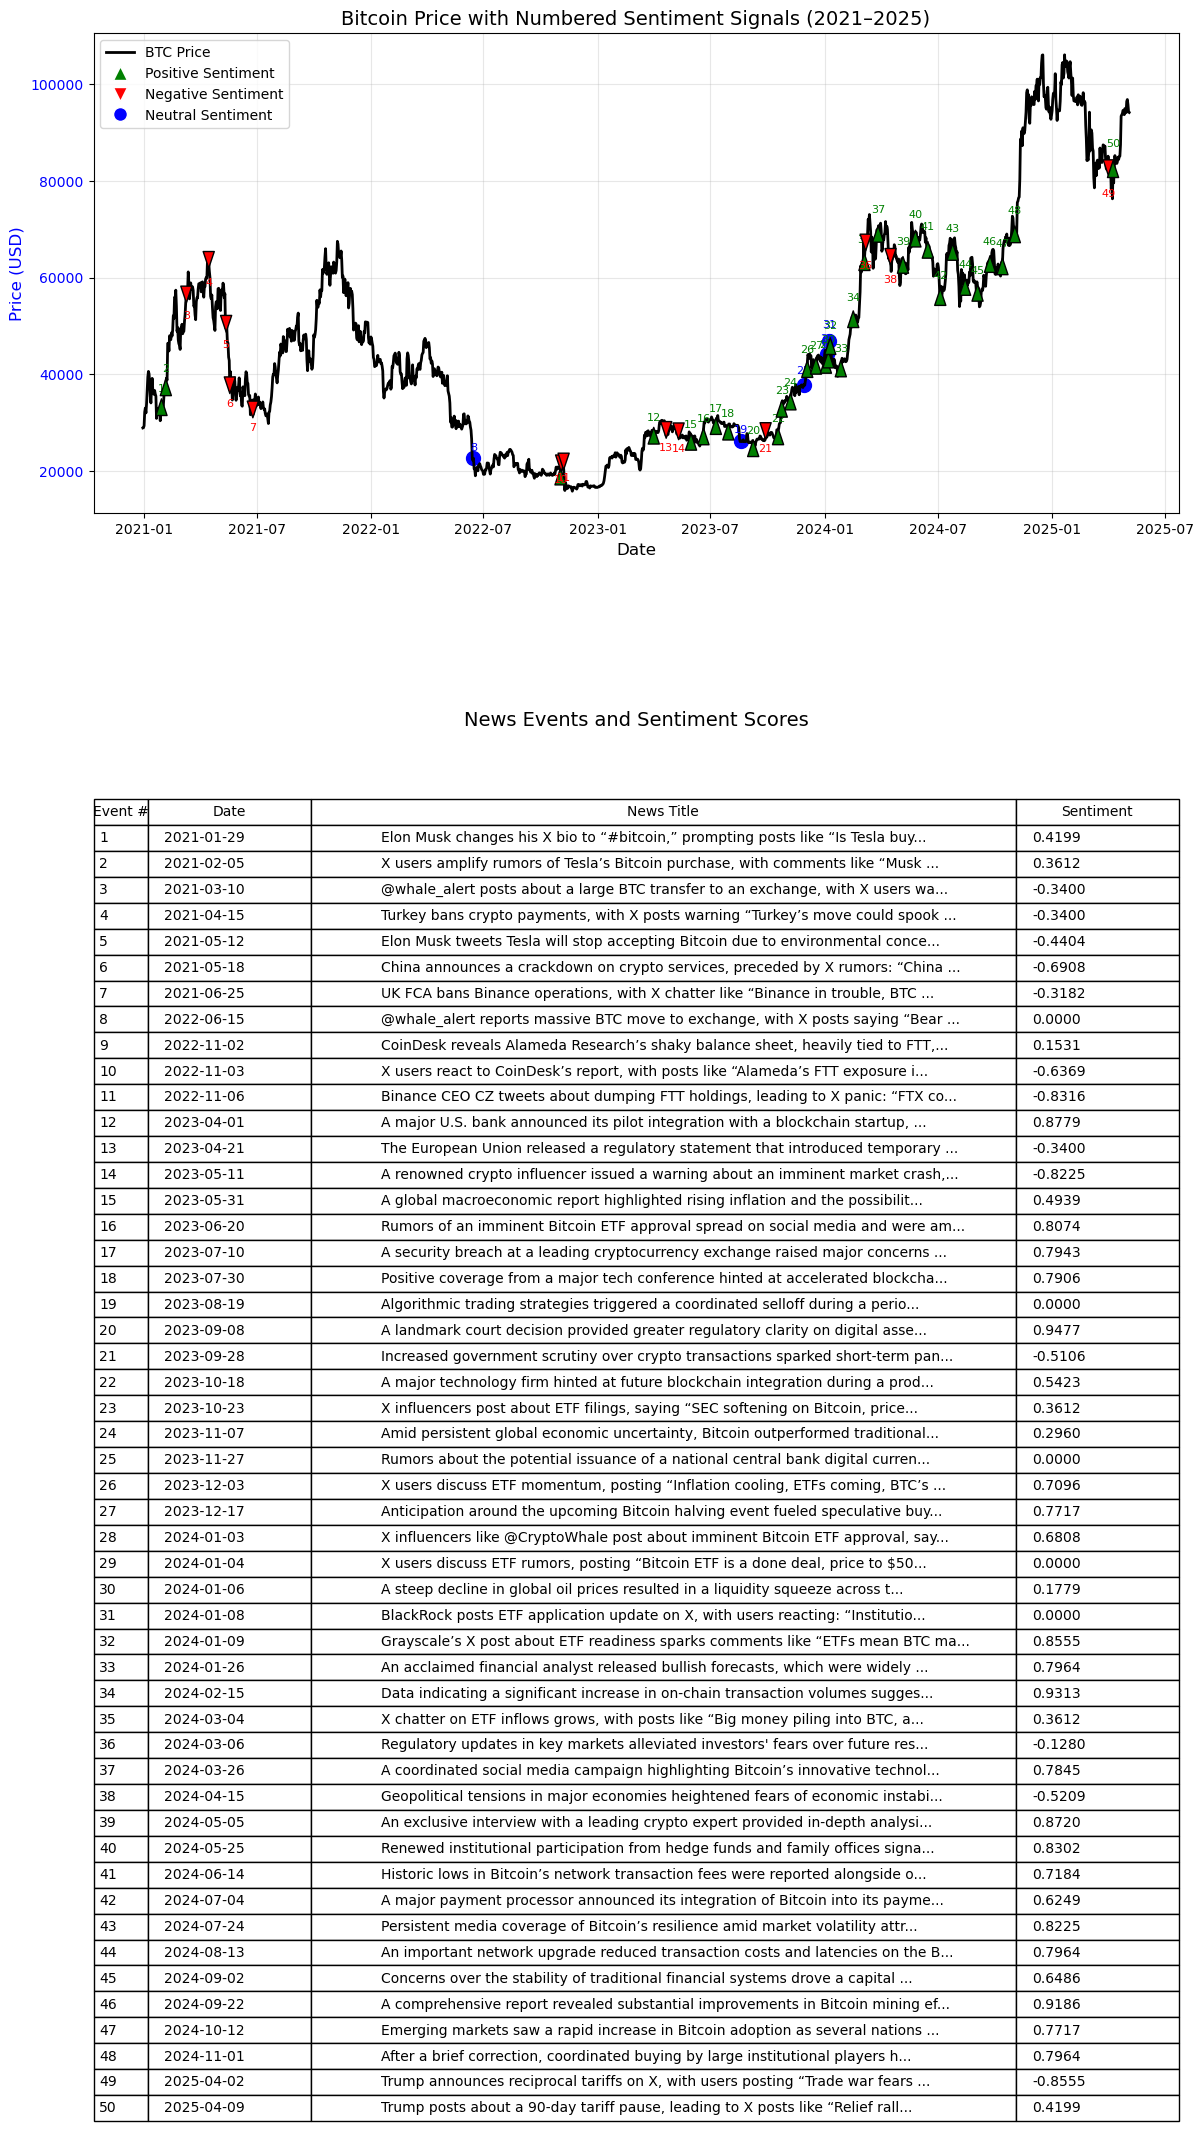

In [54]:
def main():
    """
    Main function to present data visualization of news and sentiment score for users.
    """
    # Load news from CSV. Change with your path
    csv_path = r"C:\Users\Acer\Downloads\ftec4008\FTEC4008 Report Submission\bitcoin news.csv"
    news_df = load_news_from_csv(csv_path)
    
    if news_df.empty:
        print("No news data loaded. Exiting.")
        return
    
    # Process sentiment for all news entries
    news_df = process_news_sentiment(news_df)
    
    # Determine start and end dates with a 30-day buffer
    start_date = (news_df['Published At'].min() - timedelta(days=30)).strftime('%Y-%m-%d')
    end_date = (news_df['Published At'].max() + timedelta(days=30)).strftime('%Y-%m-%d')
    print(f"Retrieving daily price data from {start_date} to {end_date}")
    
    # Fetch Bitcoin price data
    price_df = retrieve_data_from_binance(start_date=start_date, end_date=end_date)
    
    # Plot price chart with numbered sentiment markers and news table
    plot_sentiment_with_news(price_df, news_df)

if __name__ == "__main__":
    main()

In [35]:
def get_newsapi_data(query, api_key):
    """
    NEWS API DATA for future use of trading with live news
    """
    url = f"https://newsapi.org/v2/everything?q={query}&apiKey={api_key}"
    response = requests.get(url)
    return response.json()


# Replace 'YOUR_API_KEY' with your actual NewsAPI key
data = get_newsapi_data('bitcoin', 'd07af17801114cf9a05f636f205ce6d0')


# Check if the request was successful
if 'articles' in data:
    # Sort articles by publishedAt date (earliest to latest)
    sorted_articles = sorted(data['articles'], key=lambda x: x['publishedAt'])
   
    for article in sorted_articles:
        # Extract the title, description, and published date
        title = article['title']
        description = article['description']
        published_at = article['publishedAt']
        publisher = article['source']['name']  # Extract the publisher's name
        content = article.get('content', 'No content available')  # Extract the content, default to a message if not available
        url = article['url']  # Extract the URL to the original article
       
        # Print the title, description, and published date
        print(f"Title: {title}")
        print(f"Description: {description}")
        print(f"Content: {content}")
        print(f"Publisher: {publisher}")
        print(f"URL: {url}")
        print(f"Published At: {published_at}")
        print("-" * 50)
else:
    print("No articles found or an error occurred.")

Title: China Triggers Sudden Bitcoin Price ‘Crisis Scenario’ Fear
Description: Analysts are warning the bitcoin price could be headed into a “crisis scenario"...
Content: Bitcoin has fallen sharply after China announced its hitting back at Donald Trumps tariffs with a 34% charge on all U.S. goodsfeeding fears Trump dropped an atomic bomb on markets.
Front-run Donald … [+1429 chars]
Publisher: Forbes
URL: https://www.forbes.com/sites/digital-assets/2025/04/04/china-triggers-sudden-bitcoin-price-crisis-scenario-fear/
Published At: 2025-04-04T10:34:11Z
--------------------------------------------------
Title: What Are Stablecoins?
Description: Stablecoins—cryptocurrencies tied to the U.S. dollar—are gaining traction globally and in Washington, with The STABLE and GENIUS Acts.
Content: During the 2024 elections, the crypto industry spent an unprecedented amount of money on campaign donations in the hopes of encouraging Congress to pass pro-crypto legislation. Those efforts seem to … [+6549